In [1]:
import torch
from torchvision import models
from torchvision import transforms
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import math
import numpy as np

label_map = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


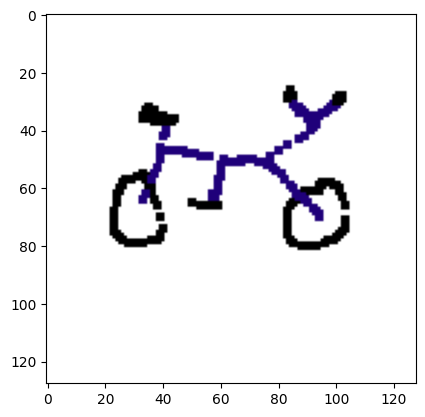

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [2]:
# Load in testing image
rgb_img = Image.open("../../data/Bicycle/Bicycle_1709008904858.png").convert("RGB")
base_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                    ])
img = base_transform(rgb_img)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(np.array(rgb_img))

In [3]:
model = models.resnet18(weights="DEFAULT")
# Add on custom classifier
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(512, 256)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(256, 10)),
    ('output', torch.nn.Softmax(dim=1))
]))

model.fc = classifier
model = model.to(device)
model.load_state_dict(torch.load("../../saved_models/TL_resnet18.pth"))
model.eval()
print("Model loaded successfully")

Model loaded successfully


In [4]:
# Make prediction
with torch.no_grad():
    squeezed_img = img.unsqueeze(0).to(device)
    output = model(squeezed_img)
    _, pred = torch.max(output, 1)
    print(f"Predicted class: {list(label_map.keys())[list(label_map.values()).index(pred.item())]}")
    print(f"Predicted class index: {pred.item()}")
    print(f"Prediction confidence: {torch.max(output).item()}")

Predicted class: Bicycle
Predicted class index: 1
Prediction confidence: 0.9999973773956299


In [5]:
def find_important_pixels(model, image, target_class, image_transform, num_pixel_groups=25, k=3) -> list:
    """
    Find the most important pixels in the image for the target class.
    For each pixel grouping, remove those pixels and check the change in the prediction score.

    Args:
        model: The model to be used for prediction
        image: The UNNORMALIZED image to be used for prediction. Shape: (3, H, W)
        target_class: The numerical class representation for the image
        image_transform: The transformations to be applied to the image
        num_pixel_groups: The number of important pixel groups to be returned
        k: The pixel grouping size (k x k pixels will be checked in each iteration)
    
    Returns:
        pixel_groups: List of the most important pixels
    """
    with torch.no_grad():
        to_tensor = transforms.ToTensor()
        image = to_tensor(image).unsqueeze(0).to(device)
        # Find the prediction score for the original image
        output = model(image)
        og_score = output[0][target_class].item()

        pixel_groups = []
        # Iterate across the image with step size k
        for i in range(0, image.shape[2], k):
            for j in range(0, image.shape[3], k):
                # Create a copy of the image
                image_copy = image.clone()
                # Remove the pixel group and normalize the image
                image_copy[:, :, i:i+k, j:j+k] = 1
                image_copy = image_transform(image_copy)
                # Get the prediction score
                output = model(image_copy)
                score_diff = og_score - output[0][target_class].item()
                # Append the pixel group and the score to the list
                pixel_groups.append((i, j, score_diff, k))

        # Sort the pixel groups by the score difference
        pixel_groups = sorted(pixel_groups, key=lambda x: x[2], reverse=True)
        return pixel_groups[:num_pixel_groups]


In [6]:
test_image = Image.open("../../data/Bicycle/Bicycle_1709008904858.png").convert("RGB")
normalize_transform = transforms.Compose([
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
                    ])
best_pixels = find_important_pixels(model=model, 
                                    image=test_image, 
                                    target_class=1, 
                                    image_transform=normalize_transform,
                                    num_pixel_groups=16,
                                    k=16)

In [7]:
def plot_important_pixels_only(original_image, important_pixel_groups, image_size, highlight=True):
    """
    Plot an image showing only the most important pixel groups, setting all other pixels to white.

    Args:
        original_image: The original image as a PIL Image.
        important_pixel_groups: A list of tuples representing the most important pixel groups.
                                Each tuple contains (i, j, score_diff, k), where (i, j) is the top-left
                                pixel of the group, score_diff is the difference in prediction score,
                                and k is the group size.
        image_size: A tuple (width, height) specifying the size of the original image.
        highlight: Whether to highlight the background of the important pixels.
    """
    # Initialize a blank white image
    new_image_array = np.ones((image_size[1], image_size[0], 3), dtype=np.uint8) * 255
    original_image = np.array(original_image)

    # Process each important pixel group
    for group in important_pixel_groups:
        i, j, _, k = group
        # Loop over each pixel in the pixel group and set it in the new image
        for dx in range(k):
            for dy in range(k):
                # Make sure we don't go out of bounds
                if i+dx < image_size[1] and j+dy < image_size[0]:
                    if highlight and original_image[i+dx, j+dy].all() == 1:
                        new_image_array[i+dx, j+dy] = 200
                    else:
                        new_image_array[i+dx, j+dy] = original_image[i+dx, j+dy]

    # Convert the array back to an image
    new_image = Image.fromarray(new_image_array)
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(new_image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


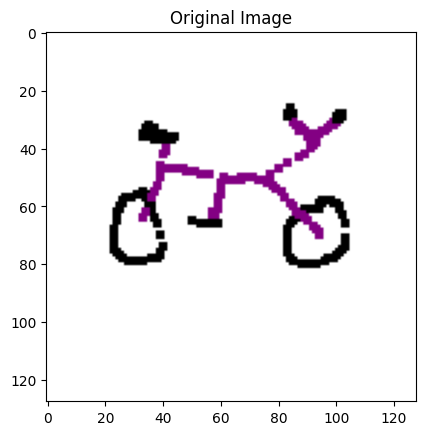

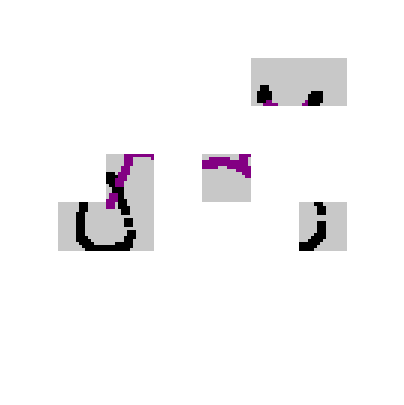

In [10]:
# Plot the original image
plt.imshow(test_image)
plt.title("Original Image")
plt.show()

# Plot the image with only the important pixels
plot_important_pixels_only(test_image, best_pixels[:7], test_image.size, highlight=True)



## Grad CAM

In [11]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [14]:
# Print out all model layers
print([name for name, module in model.named_children()])

# Define the target layer
#target_layers = [model.layer1[-1], model.layer1[-2], model.layer2[-1]]
#target_layers = [model.layer1[-1]]
target_layers = [model.layer4[-1]]

# Setup the GradCAM object and targets
cam = GradCAM(model=model, target_layers=target_layers)
target_category = 1
targets = [ClassifierOutputTarget(target_category)]

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [15]:
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=img.unsqueeze(0), targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.array(rgb_img)/255, grayscale_cam, use_rgb=True)

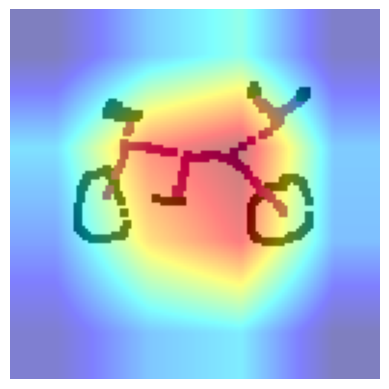

In [16]:
plt.imshow(visualization)
plt.axis('off')
plt.show()